In [1]:
import pickle
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import itertools
from scipy.sparse import csr_matrix, hstack, vstack

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_hub as hub

C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

In [2]:
file = 'D:\\MinutesOfMeeting\\sentence-classifier\\questions-types\\questions-classified.txt'
df = pd.read_csv(file, sep='\t', header=None)

In [3]:
df.shape

(1483, 2)

In [4]:
df.head()

,0,1
0,how did serfdom develop in and then leave russ...,unknown
1,what films featured the character popeye doyle ?,what
2,how can i find a list of celebrities ' real na...,unknown
3,what fowl grabs the spotlight after the chines...,what
4,what is the full form of .com ?,what


In [5]:
df.rename(columns={0: 'text', 1: 'type'}, inplace=True)
df['type'] = df['type'].str.strip()
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s\']', '', x)))

In [6]:
df.head()

,text,type
0,how did serfdom develop in and then leave russia,unknown
1,what films featured the character popeye doyle,what
2,how can i find a list of celebrities ' real na...,unknown
3,what fowl grabs the spotlight after the chines...,what
4,what is the full form of com,what


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 2 columns):
text    1483 non-null object
type    1483 non-null object
dtypes: object(2)
memory usage: 23.2+ KB


In [8]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df['type'])
df['label'] = list(label_encoder.transform(df['type']))

In [9]:
df.shape

(1483, 3)

In [10]:
df.head()

,text,type,label
0,how did serfdom develop in and then leave russia,unknown,1
1,what films featured the character popeye doyle,what,2
2,how can i find a list of celebrities ' real na...,unknown,1
3,what fowl grabs the spotlight after the chines...,what,2
4,what is the full form of com,what,2


In [11]:
reverse_mapping = [df[df['label'] == i].iloc[0].type for i in range(5)]
reverse_mapping

['affirmation', 'unknown', 'what', 'when', 'who']

In [12]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        i = 0
        name = t[0]
        # if not t[1].isdigit():
        #   i = 1
        #   name += " " + t[1]
        classes.append(name)
        v = [float(x) for x in t[i+1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(name)
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

In [13]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### SVD with Count Vectorizer

In [14]:
vectorizer = CountVectorizer(analyzer='word', lowercase=True)
X = vectorizer.fit_transform(df['text'])
with open('vocab.bin', 'wb') as vocab_file:
    pickle.dump(vectorizer.vocabulary_, vocab_file)
X_train, X_test, y_train, y_test = train_test_split(X, df['type'], test_size=0.3)
clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
preds = clf_svm.predict(X_test)

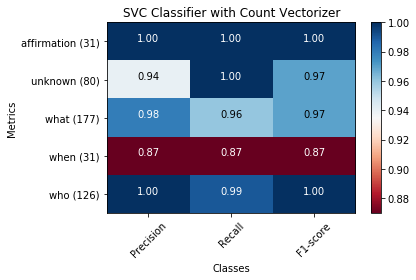

In [15]:
classification = classification_report(preds, y_test)
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('SVC Classifier with Count Vectorizer')
plt.show()
plt.close()

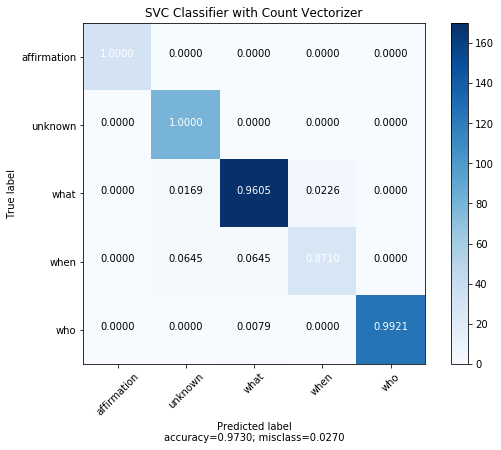

In [16]:
cm = confusion_matrix(preds, y_test)
plot_confusion_matrix(cm, reverse_mapping,title='SVC Classifier with Count Vectorizer')

### SVD with Universal Sentence Encoder

In [17]:
embed = hub.load("D:\\Embeddings\\universal-sentence-encoder_4")

In [18]:
embeddings = embed(df['text'])

In [19]:
embeddings.shape

TensorShape([Dimension(1483), Dimension(512)])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(embeddings.numpy(), df['type'], test_size=0.3)
clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train, y_train)
preds = clf_svm.predict(X_test)

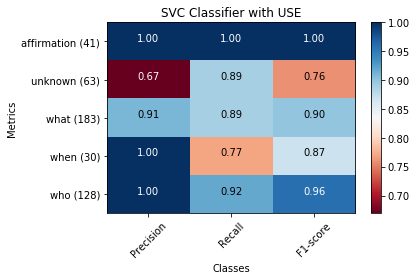

In [21]:
classification = classification_report(preds, y_test)
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('SVC Classifier with USE')
plt.show()
plt.close()

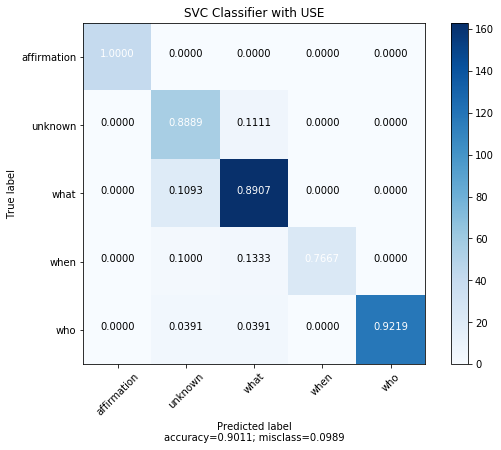

In [22]:
cm = confusion_matrix(preds, y_test)
plot_confusion_matrix(cm, reverse_mapping,title='SVC Classifier with USE')

In [23]:
# SVM classifier

# reducing the number of features using Singular Value Decomposition
svd = TruncatedSVD(n_components = 15)
svd.fit(vstack((X_train, X_test)).tocsr())
x_train_svd = svd.transform(X_train)
x_test_svd = svd.transform(X_test)

# scaling the data obtained from SVD
scaler = StandardScaler()
scaler.fit(np.concatenate((x_train_svd, x_test_svd)))
x_train_svd = scaler.transform(x_train_svd)
x_test_svd = scaler.transform(x_test_svd)

clf = SVC(C = 0.1, probability = True)
clf.fit(x_train_svd, y_train)

preds = clf.predict(x_test_svd)

C:\Users\Mehdi Raza\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


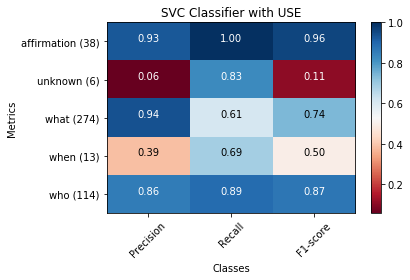

In [24]:
classification = classification_report(preds, y_test)
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('SVC Classifier with USE')
plt.show()
plt.close()

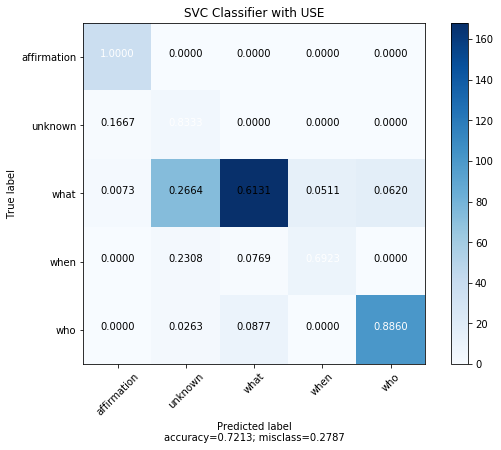

In [25]:
cm = confusion_matrix(preds, y_test)
plot_confusion_matrix(cm, reverse_mapping,title='SVC Classifier with USE')